In [1]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
##################  Загрузка данных
#Data1 = pd.read_csv('D:\Coding\data\phone_user_review_file_1.csv', encoding= 'ANSI')
#Data2 = pd.read_csv('D:\Coding\data\phone_user_review_file_2.csv', encoding= 'ANSI')
#Data3 = pd.read_csv('D:\Coding\data\phone_user_review_file_3.csv', encoding= 'ANSI')
#Data4 = pd.read_csv('D:\Coding\data\phone_user_review_file_4.csv', encoding= 'ANSI')
#Data5 = pd.read_csv('D:\Coding\data\phone_user_review_file_5.csv', encoding= 'ANSI')
Data6 = pd.read_csv('D:\Coding\data\phone_user_review_file_6.csv', encoding= 'ANSI')

#total_data = pd.concat([Data1,Data2, Data3, Data4, Data5, Data6], axis=0)
total_data = Data6

total_data.shape

(163837, 11)

In [3]:
total_data[['lang', 'score', 'extract']].head()

,lang,score,extract
0,en,8.0,I've had the phone for awhile and it's a prett...
1,en,6.0,to be clear it is not the sellers fault that t...
2,en,9.0,Well i love this phone. i have had ton of phon...
3,en,4.0,I have had my Instinct for several months now ...
4,en,6.0,i have had this instinct phone for about two m...


In [4]:
##################  Препроцессинг

In [5]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [7]:
data = total_data[(total_data.lang == 'en')]
data = data[['score', 'extract']]
data = data.dropna()

In [8]:
print("data.shape(): ", data.shape)

data.shape():  (49093, 2)


In [9]:
data['content_clear'] = data['extract'].apply(review_to_wordlist)

In [10]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['phone', 'awhile', 'pretty', 'good', 'phone', 'call', 'quality', 'response', 'sms', 'mms', 'much', 'faster', 'data', 'g', 'runs', 'like', 'g', 'network', 'phone', 'pretty', 'much', 'like', 'android', 'except', 'without', 'widgets', 'market']


In [11]:
def er_funtion(cc):

    if (cc <= 3):
        l = 1
    elif (cc >= 7):
        l = 3
    else:
        l = 2

    return (l)

In [12]:
data['mapped_y'] = data['score'].apply(er_funtion)

############## Word2vec ##############

In [13]:
import gensim
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Скачивание готовой натренированной модели 
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('D:\Coding\Word2vec\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

print("Done!")

Done!


In [15]:
# Посмотрим чему выучилась модель:
#model_w2v.wv.most_similar(positive=['phone'])

[('telephone', 0.8224020600318909),
 ('cell_phone', 0.7831966876983643),
 ('cellphone', 0.7629485130310059),
 ('Phone', 0.7060797810554504),
 ('phones', 0.6894922256469727),
 ('landline', 0.6263927221298218),
 ('voicemail', 0.6252243518829346),
 ('caller_id', 0.6023745536804199),
 ('RingCentral_cloud_computing', 0.5935890674591064),
 ('telephones', 0.5929964780807495)]

############## mean_vectorizer ##############

In [14]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [15]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(49093, 300)

In [16]:
from sklearn.model_selection import train_test_split

y = data['mapped_y']
Xtr, Xval, ytr, yval = train_test_split(data_mean, y, test_size=0.33, random_state=42)

In [17]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (32892, 300) 
Xval.shape():  (16201, 300) 
ytr.mean():  2.5148364343913414 
yval.mean():  2.513733720140732


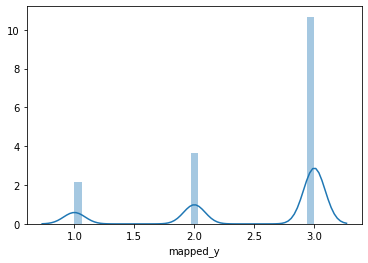

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

############# RandomForestRegressor подготовка #############

In [19]:
ytr[:10]

66734     3
62376     3
78493     1
89276     1
73820     3
48015     3
41700     3
134363    3
109962    3
96023     3
Name: mapped_y, dtype: int64

In [20]:
from sklearn import utils
ytr1 = ytr.astype('int')
yval1 = yval.astype('int')
utils.multiclass.type_of_target(ytr1)

'multiclass'

In [21]:
ytr1[:10]

66734     3
62376     3
78493     1
89276     1
73820     3
48015     3
41700     3
134363    3
109962    3
96023     3
Name: mapped_y, dtype: int32

############# RandomForestRegressor #############

In [22]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor()
regr.fit(Xtr, ytr1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [23]:
y_pred_reg=regr.predict(Xtr)
y_pred_reg[:10]

array([2.86 , 2.79 , 1.455, 1.62 , 2.65 , 2.88 , 2.93 , 2.92 , 2.66 ,
       2.85 ])

In [24]:
y_pred_val_reg=regr.predict(Xval)
y_pred_val_reg[:10]

array([2.91, 2.9 , 2.7 , 2.91, 2.56, 2.36, 2.62, 2.64, 2.8 , 2.21])

In [25]:
df = pd.DataFrame(list(zip(y_pred_val_reg, yval)),
                                 columns = ['y_pred_val_reg', 'yval'])
df.head(30)

,y_pred_val_reg,yval
0,2.91,3
1,2.90,2
2,2.70,2
3,2.91,2
4,2.56,3
5,2.36,2
6,2.62,3
7,2.64,3
8,2.80,3
9,2.21,3


In [26]:
regr.score(Xval, yval1)

0.21271361175771386

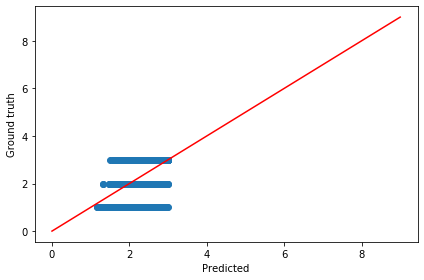

In [27]:

########## Scatter plot валидация (оценка модели)

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_val_reg, yval)
plt.xlabel('Predicted')
plt.ylabel('Ground truth')

plt.plot([0, 9], [0, 9], color = "red")
plt.tight_layout()
plt.show()